<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/Untitled225Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mega.py

from mega import Mega

# Crie uma instância da classe Mega
mega = Mega()

# Cole o link completo do Mega.nz (incluindo a chave)
url = "https://mega.nz/file/tu0GXQzL#BGoVzch2_6s2EEQYLfkwpct1Uq-ZrRL2sHCOY54vohs"

# Use o link completo para fazer o download
mega.download_url(url)

!unzip vegetables.v4i.yolov8.zip

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 8.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 27.1/225.8 GB disk)


In [4]:
train_path='/content/vegetables/train'
valid_path='/content/vegetables/valid'
test_path='/content/vegetables/test'

In [5]:
names =['vegetables']
M=list(range(len(names)))
class_map=dict(zip(M,names))

In [6]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 150MB/s]


In [7]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/vegetables/data.yaml epochs=30 imgsz=480

Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/vegetables/data.yaml, epochs=30, patience=50, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchs

In [8]:
paths2=[]
for dirname, _, filenames in os.walk('/content/runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)

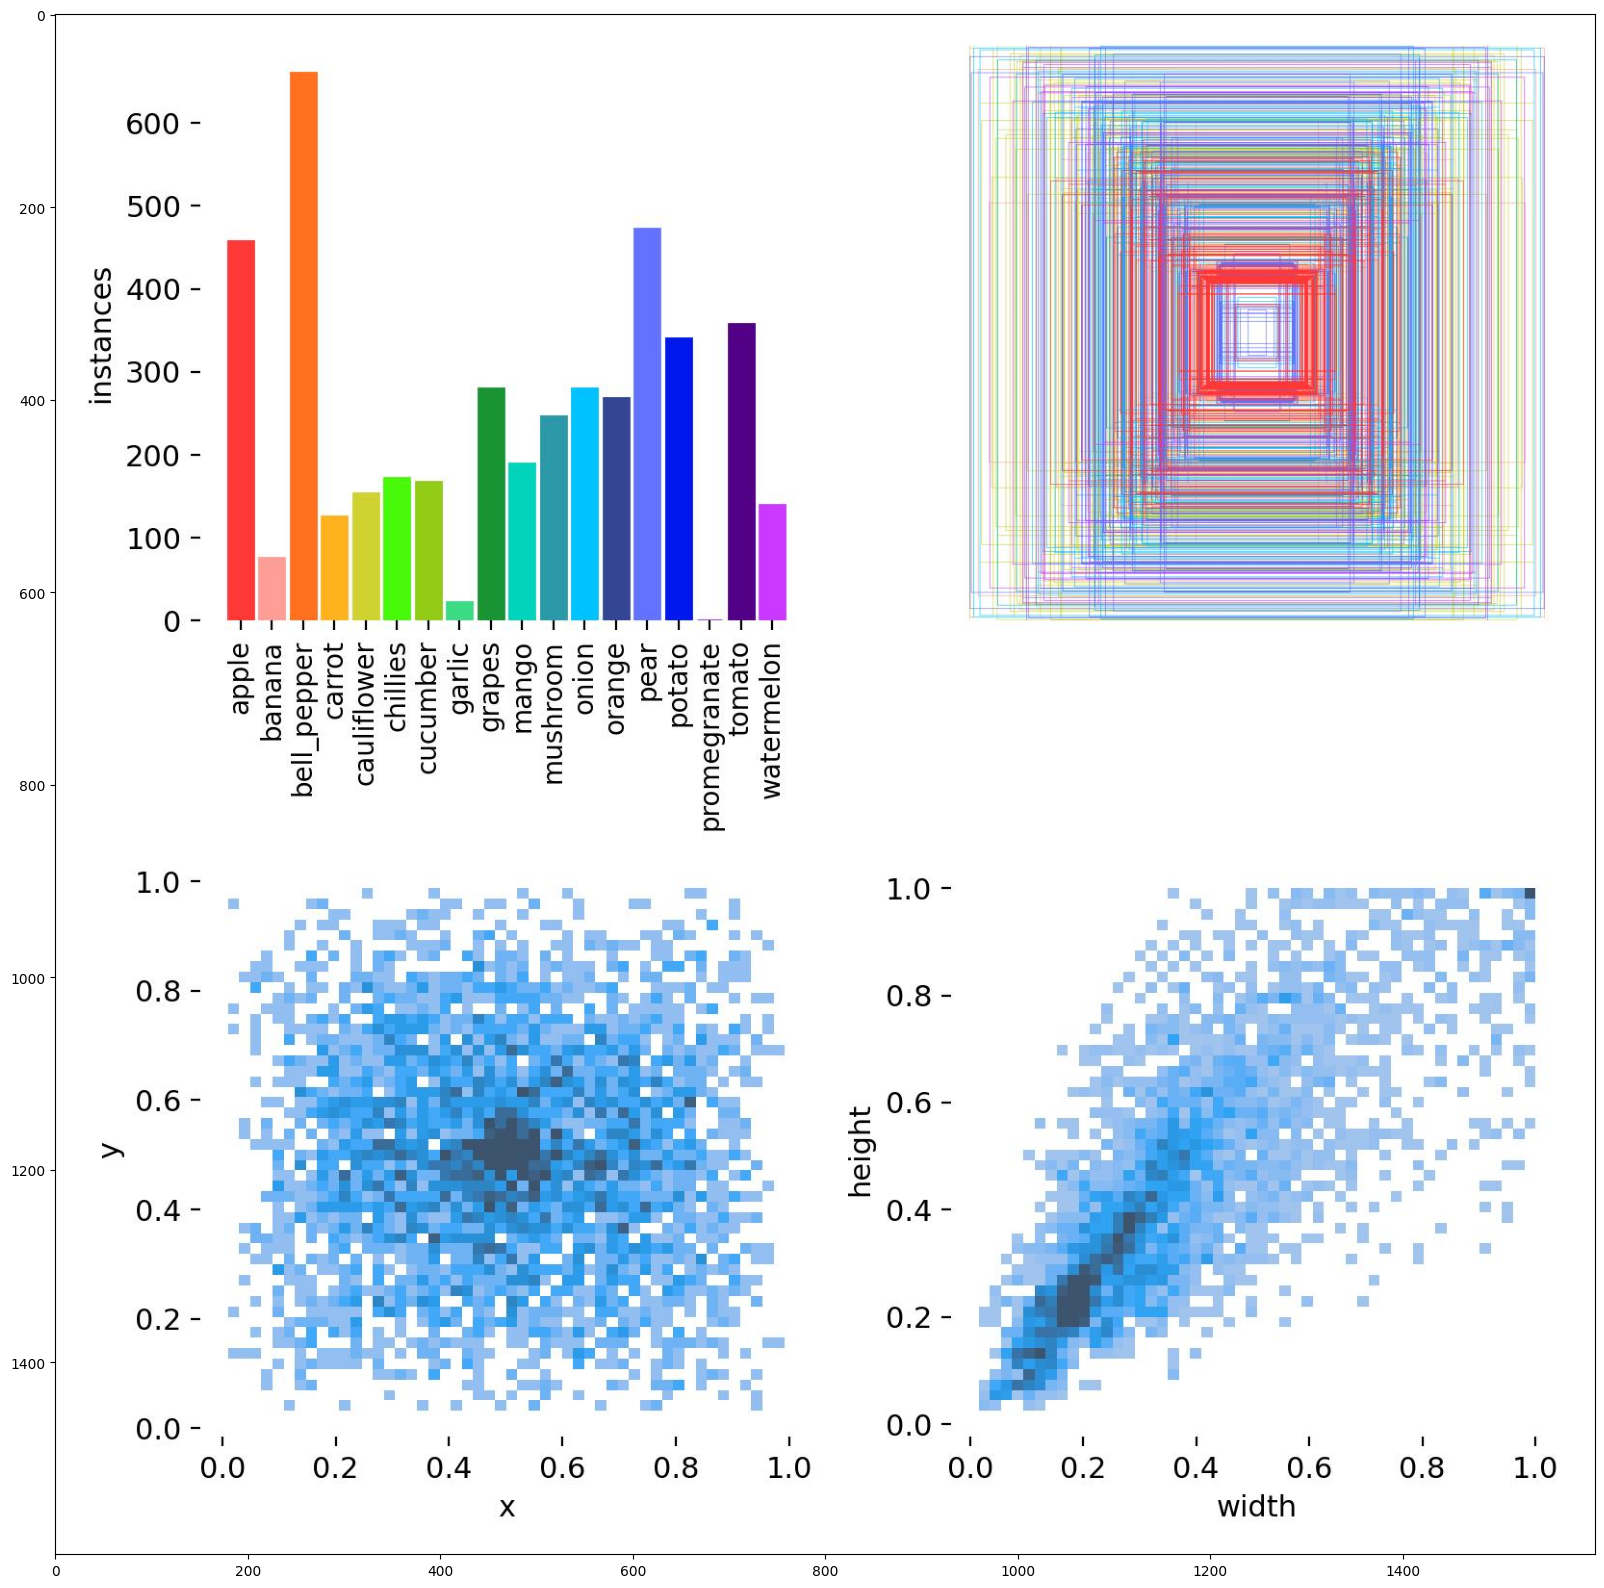

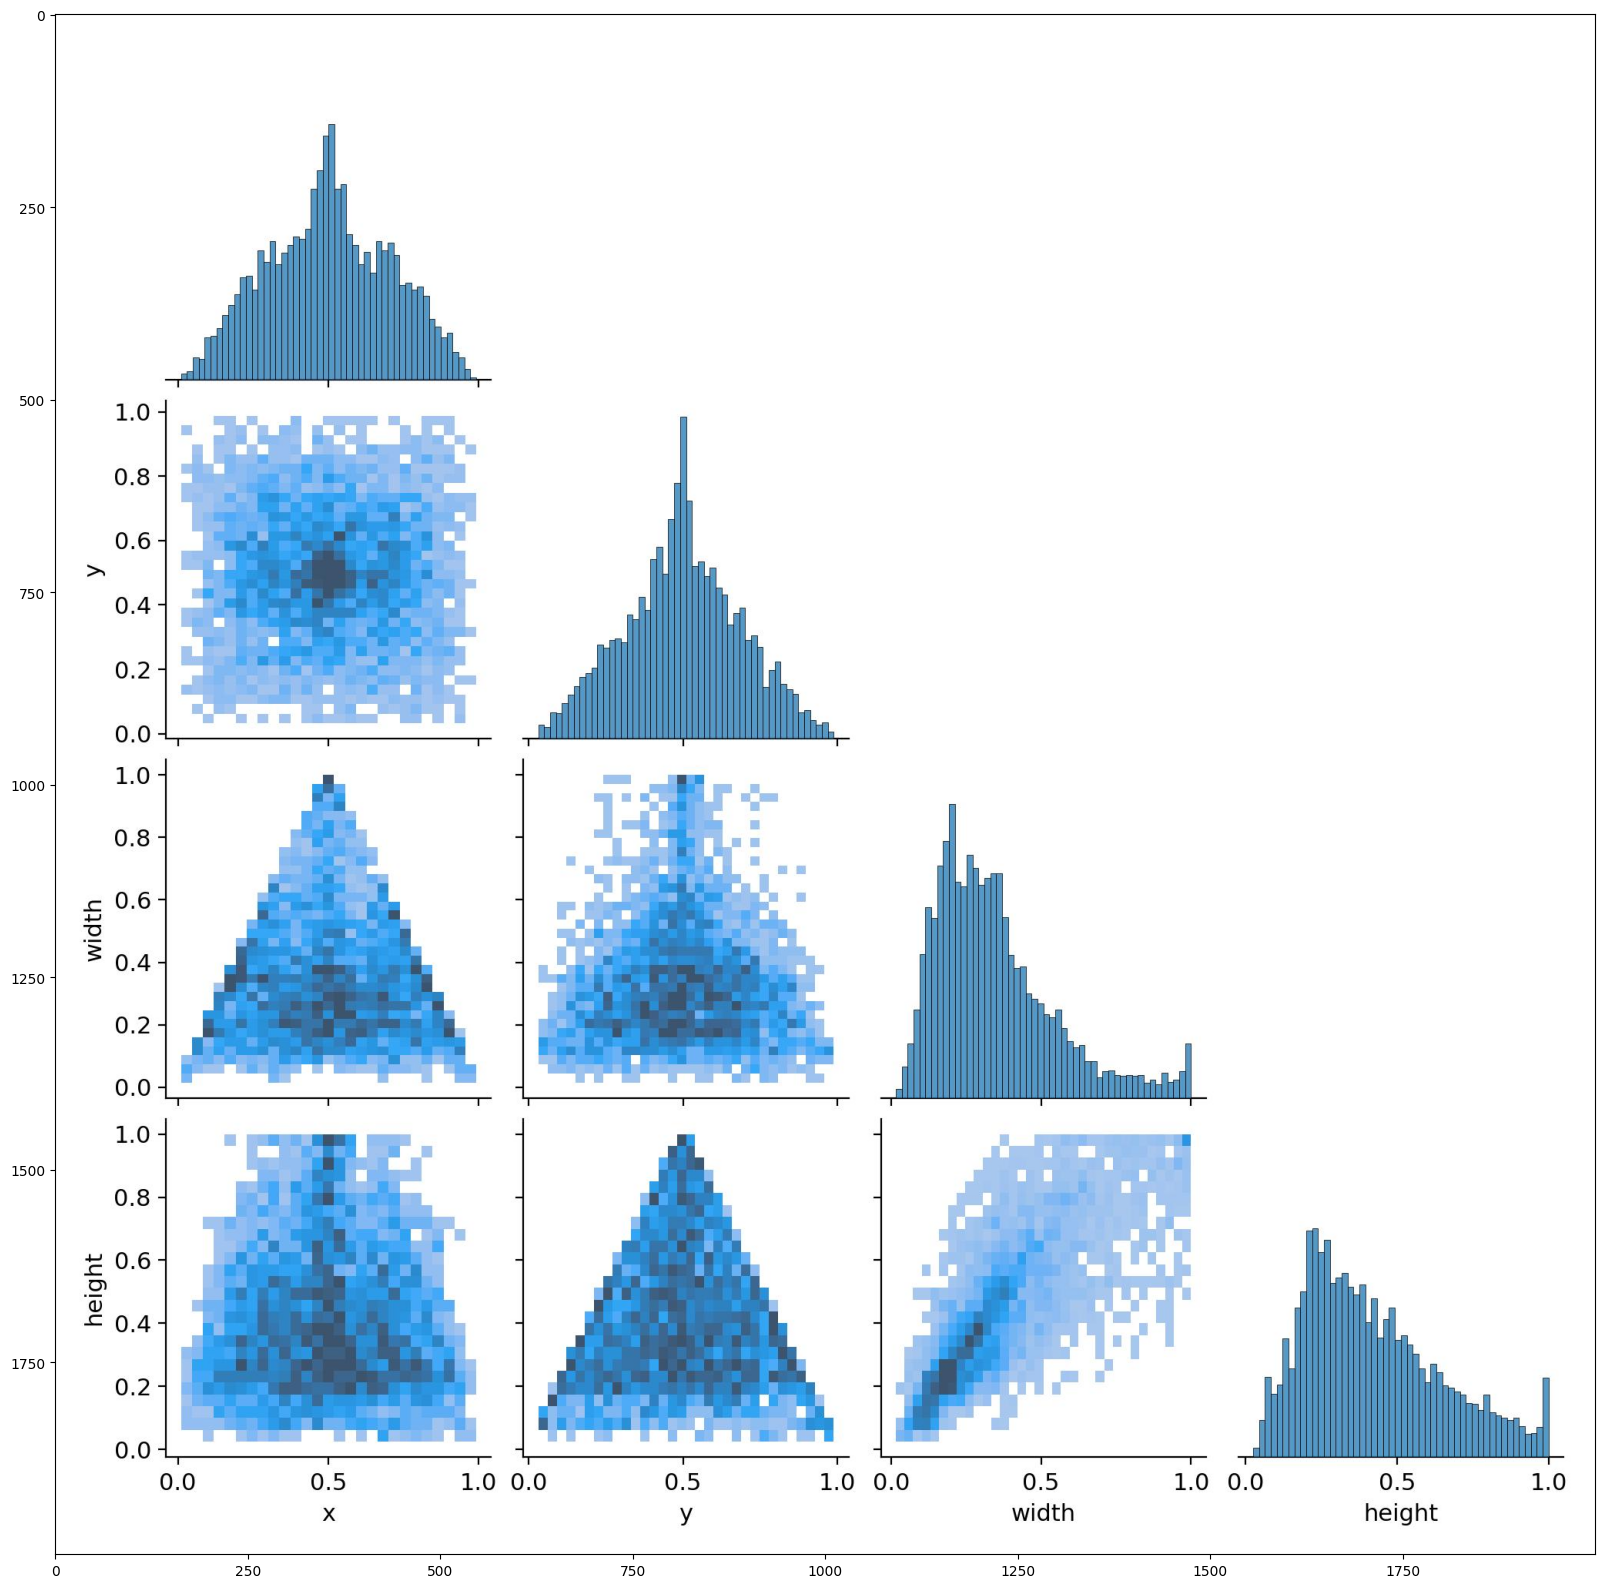

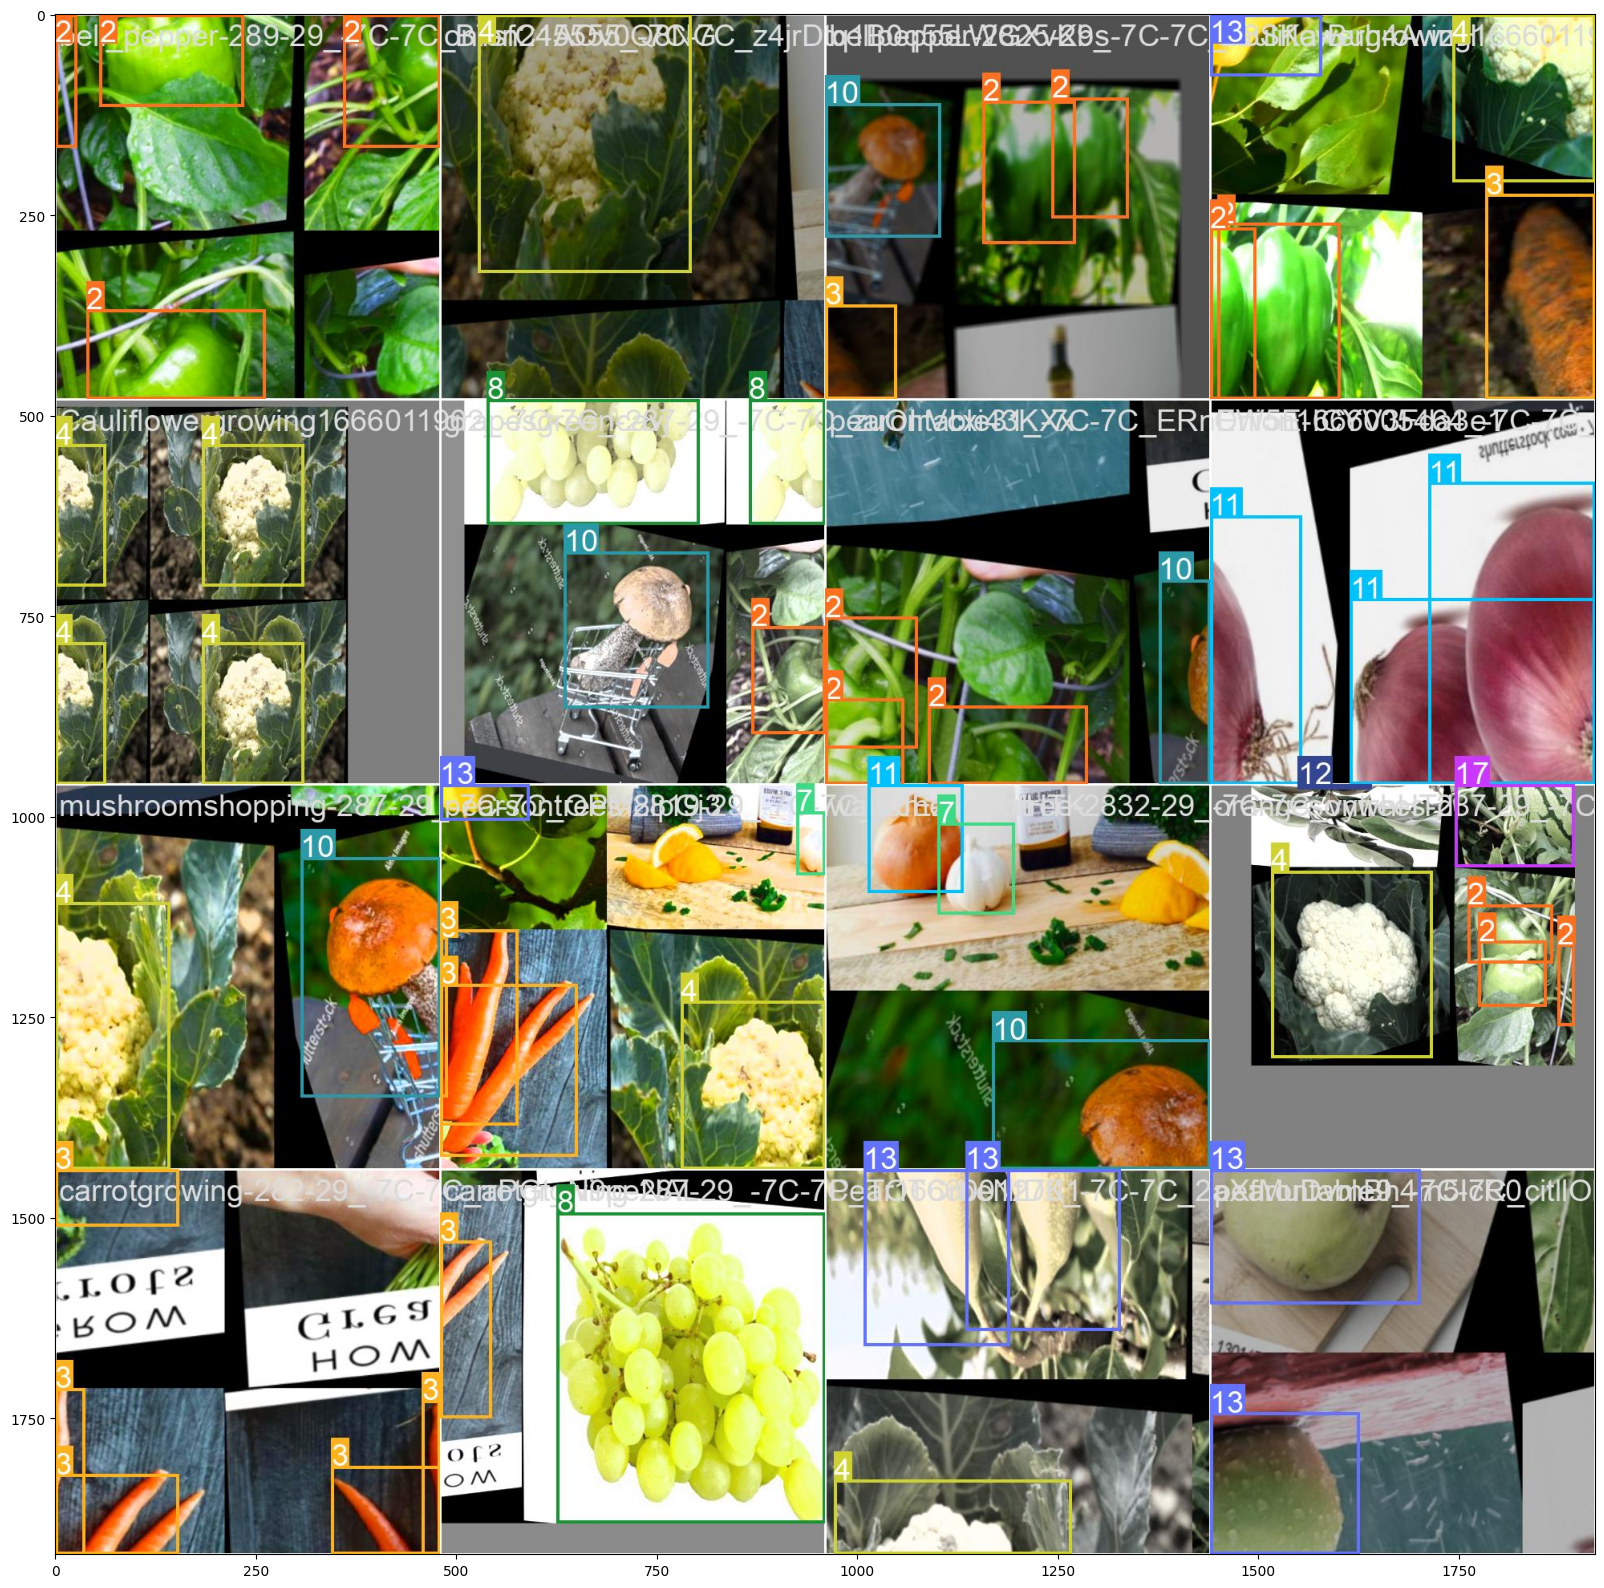

In [ ]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    plt.show()

In [10]:
best_path0='/content/runs/detect/train/weights/best.pt'
source0=test_path

In [11]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
#print(ppaths[0])
#print(len(ppaths))

In [12]:
model2 = YOLO(best_path0)

In [13]:
!yolo task=detect mode=predict model={best_path0} conf=0.2 source={source0}

Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3009158 parameters, 0 gradients, 8.1 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 448, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 239, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 207, in predict_cli
    for _ in gen:  # running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in generator_context
    response = gen.send(None)
  File "

In [ ]:
results = model2.predict(source0,conf=0.2)
#print(len(results))

In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
#display(PBOX)

In [ ]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
#display(PBOX)
#display(PBOX['class'].value_counts())

In [ ]:
def draw_box2(n0):

    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]

    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            conf=box.loc[i,'confidence']
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2'])
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.putText(image, f'{round(conf,3)}', (x, int(y-4)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0),1)
            cv2.rectangle(image,(x,y),(x2,y2),(0,255,0),1) #green

    #plt.imshow(image)
    #plt.show()

    return image

In [ ]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {i}')
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

In [ ]:
create_animation(images2)